In [2]:
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
# from tqdm.notebook import trange, tqdm
from PIL import Image

%matplotlib inline


In [ ]:
%pip install albumentations


In [3]:
root_dir = r'C:\Users\User\segment\tiff'
random_seed = 42 
batch_size = 10

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
class_df = pd.read_csv(r'C:\Users\User\segment\dataset\label_class_dict.csv')
class_df

,name,r,g,b
0,background,0,0,0
1,road,255,255,255


In [5]:
data_df = pd.read_csv(r'C:\Users\User\segment\dataset\metadata.csv')
data_df

,image_id,split,image_souce_url,label_source_url,tiff_image_path,tif_label_path,png_image_path,png_label_path
0,10078660_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078660_15.tiff,tiff/train_labels/10078660_15.tif,png/train/10078660_15.png,png/train_labels/10078660_15.png
1,10078675_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078675_15.tiff,tiff/train_labels/10078675_15.tif,png/train/10078675_15.png,png/train_labels/10078675_15.png
2,10078690_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078690_15.tiff,tiff/train_labels/10078690_15.tif,png/train/10078690_15.png,png/train_labels/10078690_15.png
3,10078705_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078705_15.tiff,tiff/train_labels/10078705_15.tif,png/train/10078705_15.png,png/train_labels/10078705_15.png
4,10078720_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078720_15.tiff,tiff/train_labels/10078720_15.tif,png/train/10078720_15.png,png/train_labels/10078720_15.png
...,...,...,...,...,...,...,...,...
1166,25079170_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/25079170_15.tiff,tiff/test_labels/25079170_15.tif,png/test/25079170_15.png,png/test_labels/25079170_15.png
1167,26278720_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/26278720_15.tiff,tiff/test_labels/26278720_15.tif,png/test/26278720_15.png,png/test_labels/26278720_15.png
1168,26428735_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/26428735_15.tiff,tiff/test_labels/26428735_15.tif,png/test/26428735_15.png,png/test_labels/26428735_15.png
1169,26578720_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/26578720_15.tiff,tiff/test_labels/26578720_15.tif,png/test/26578720_15.png,png/test_labels/26578720_15.png


In [6]:
train_df = data_df.loc[data_df['split'] == 'train']
print(f"В test содержится {len(train_df)} изображений")
train_df

В test содержится 1108 изображений


,image_id,split,image_souce_url,label_source_url,tiff_image_path,tif_label_path,png_image_path,png_label_path
0,10078660_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078660_15.tiff,tiff/train_labels/10078660_15.tif,png/train/10078660_15.png,png/train_labels/10078660_15.png
1,10078675_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078675_15.tiff,tiff/train_labels/10078675_15.tif,png/train/10078675_15.png,png/train_labels/10078675_15.png
2,10078690_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078690_15.tiff,tiff/train_labels/10078690_15.tif,png/train/10078690_15.png,png/train_labels/10078690_15.png
3,10078705_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078705_15.tiff,tiff/train_labels/10078705_15.tif,png/train/10078705_15.png,png/train_labels/10078705_15.png
4,10078720_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/10078720_15.tiff,tiff/train_labels/10078720_15.tif,png/train/10078720_15.png,png/train_labels/10078720_15.png
...,...,...,...,...,...,...,...,...
1103,27028705_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/27028705_15.tiff,tiff/train_labels/27028705_15.tif,png/train/27028705_15.png,png/train_labels/27028705_15.png
1104,27028720_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/27028720_15.tiff,tiff/train_labels/27028720_15.tif,png/train/27028720_15.png,png/train_labels/27028720_15.png
1105,27178705_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/27178705_15.tiff,tiff/train_labels/27178705_15.tif,png/train/27178705_15.png,png/train_labels/27178705_15.png
1106,99238660_15,train,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/train/99238660_15.tiff,tiff/train_labels/99238660_15.tif,png/train/99238660_15.png,png/train_labels/99238660_15.png


In [7]:

val_df = data_df.loc[data_df['split'] == 'val']
print(f"В test содержится {len(val_df)} изображений")
val_df

В test содержится 14 изображений


,image_id,split,image_souce_url,label_source_url,tiff_image_path,tif_label_path,png_image_path,png_label_path
1108,10228690_15,val,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/val/10228690_15.tiff,tiff/val_labels/10228690_15.tif,png/val/10228690_15.png,png/val_labels/10228690_15.png
1109,10978735_15,val,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/val/10978735_15.tiff,tiff/val_labels/10978735_15.tif,png/val/10978735_15.png,png/val_labels/10978735_15.png
1110,10978795_15,val,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/val/10978795_15.tiff,tiff/val_labels/10978795_15.tif,png/val/10978795_15.png,png/val_labels/10978795_15.png
1111,18028945_15,val,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/val/18028945_15.tiff,tiff/val_labels/18028945_15.tif,png/val/18028945_15.png,png/val_labels/18028945_15.png
1112,21929020_15,val,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/val/21929020_15.tiff,tiff/val_labels/21929020_15.tif,png/val/21929020_15.png,png/val_labels/21929020_15.png
1113,22528900_15,val,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/val/22528900_15.tiff,tiff/val_labels/22528900_15.tif,png/val/22528900_15.png,png/val_labels/22528900_15.png
1114,22829035_15,val,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/val/22829035_15.tiff,tiff/val_labels/22829035_15.tif,png/val/22829035_15.png,png/val_labels/22829035_15.png
1115,22978990_15,val,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/val/22978990_15.tiff,tiff/val_labels/22978990_15.tif,png/val/22978990_15.png,png/val_labels/22978990_15.png
1116,23128930_15,val,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/val/23128930_15.tiff,tiff/val_labels/23128930_15.tif,png/val/23128930_15.png,png/val_labels/23128930_15.png
1117,24179245_15,val,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/val/24179245_15.tiff,tiff/val_labels/24179245_15.tif,png/val/24179245_15.png,png/val_labels/24179245_15.png


In [8]:
test_df = data_df.loc[data_df['split'] == 'test']
print(f"В test содержится {len(test_df)} изображений")
test_df[:10]

В test содержится 49 изображений


,image_id,split,image_souce_url,label_source_url,tiff_image_path,tif_label_path,png_image_path,png_label_path
1122,10378780_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/10378780_15.tiff,tiff/test_labels/10378780_15.tif,png/test/10378780_15.png,png/test_labels/10378780_15.png
1123,10828720_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/10828720_15.tiff,tiff/test_labels/10828720_15.tif,png/test/10828720_15.png,png/test_labels/10828720_15.png
1124,11128870_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/11128870_15.tiff,tiff/test_labels/11128870_15.tif,png/test/11128870_15.png,png/test_labels/11128870_15.png
1125,11278840_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/11278840_15.tiff,tiff/test_labels/11278840_15.tif,png/test/11278840_15.png,png/test_labels/11278840_15.png
1126,11728825_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/11728825_15.tiff,tiff/test_labels/11728825_15.tif,png/test/11728825_15.png,png/test_labels/11728825_15.png
1127,12328750_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/12328750_15.tiff,tiff/test_labels/12328750_15.tif,png/test/12328750_15.png,png/test_labels/12328750_15.png
1128,15928855_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/15928855_15.tiff,tiff/test_labels/15928855_15.tif,png/test/15928855_15.png,png/test_labels/15928855_15.png
1129,16078870_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/16078870_15.tiff,tiff/test_labels/16078870_15.tif,png/test/16078870_15.png,png/test_labels/16078870_15.png
1130,17878735_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/17878735_15.tiff,tiff/test_labels/17878735_15.tif,png/test/17878735_15.png,png/test_labels/17878735_15.png
1131,17878780_15,test,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,http://www.cs.toronto.edu/~vmnih/data/mass_roa...,tiff/test/17878780_15.tiff,tiff/test_labels/17878780_15.tif,png/test/17878780_15.png,png/test_labels/17878780_15.png


In [9]:
class RoadDataset(Dataset):
    def __init__(self, df, mode, root=root_dir):
        self.df = df
        self.rescale_size = 1024
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    def aug(self, image, mask):
        if self.mode == "train":
            transform = A.Compose([
                A.Resize(1024, 1024),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Normalize(mean=[0.5], std=[0.25]),
                ToTensorV2(),
            ])
        else:
            transform = A.Compose([
                A.Resize(1024, 1024),
                A.Normalize(mean=[0.5], std=[0.25]),
                ToTensorV2(),
            ])
        transformed = transform(image=image, mask=mask)
        return transformed['image'], transformed['mask']
        
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['tiff_image_path']
        mask_path = self.df.iloc[idx]['tif_label_path']
        image = Image.open(img_path)
        label = Image.open(mask_path)

        bw_image_array = np.array(label)
        color_image_array = np.array(image)

        top_left_x = random.randint(0, 1500 - 1024)
        top_left_y = random.randint(0, 1500 - 1024)
            
        bw_square = bw_image_array[top_left_y:top_left_y + 224, top_left_x:top_left_x + 1024]
            
        color_square = color_image_array[top_left_y:top_left_y + 224, top_left_x:top_left_x + 1024, :]

        white_pixels = np.sum(bw_square == 1)
        total_pixels = np.prod(bw_square.shape)
        while (white_pixels / total_pixels) < 0.02:
            top_left_x = random.randint(0, 1500 - 1024)
            top_left_y = random.randint(0, 1500 - 1024)
            bw_square = bw_image_array[top_left_y:top_left_y + 1024, top_left_x:top_left_x + 1024]
            color_square = color_image_array[top_left_y:top_left_y + 1024, top_left_x:top_left_x + 1024, :]
            white_pixels = np.sum(bw_square == 255)
            total_pixels = np.prod(bw_square.shape)

        image, mask = self.aug(color_square, bw_square)
        
        return image, mask


In [10]:
train_dataset = RoadDataset(train_df, "train")
val_dataset = RoadDataset(val_df, "val")
test_dataset = RoadDataset(test_df, "test")

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)
len(train_dataset)
len(train_loader)

111

In [47]:
inputs, targets = test_dataset[1]

In [ ]:
# %pip install ipywidgets

In [11]:
import re
import os
def get_log_num(path):
    log_list = list(filter(re.compile('best_*').match, os.listdir(path)))
    log_list = list([s.replace('best_', '') for s in log_list])
    log_list = list([s.replace('.pt', '') for s in log_list])
    if not log_list:
        return 0
    return max(list(map(float, log_list)))

In [16]:
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
num_epochs = 30
base_lr = 0.001
model = smp.Unet(encoder_name='resnet34', in_channels=3, classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

best_iou = 0
train_loss_arr = []
train_iou_arr = []
val_loss_arr = []
val_iou_arr = []

for epoch in range(num_epochs):

    train_loss_ep = 0
    train_iou_ep = 0
    train_loss = 0
    train_iou= 0

    val_loss_ep = 0
    val_iou_ep = 0
    val_loss = 0
    val_iou= 0

    print(f"Epoch {epoch+1}/{num_epochs}")

    for data,labels in train_loader:
        labels[labels == 255] = 1
        model.train()
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        pred = model(data)
        labels = labels.float().unsqueeze(1)
        
        pred = pred.to(device)
        loss = criterion(pred,labels)
        loss.backward()
        optimizer.step()
        
        predicted_masks = (pred > 0.5).float()
        intersection = torch.logical_and(predicted_masks, labels).sum().item()
        union = torch.logical_or(predicted_masks, labels).sum().item()
        iou = intersection / union if union != 0 else 0
        
        train_loss_ep += loss.item()
        train_iou_ep += iou

    train_iou = train_iou_ep / len(train_loader)
    train_loss = train_loss_ep / len(train_loader)

    train_loss_arr.append(train_loss)
    train_iou_arr.append(train_iou)
    print(f"Mean train loss at this stage is {train_loss}, IoU = {train_iou}")


    with torch.no_grad():

        for data,labels in val_loader:
            labels[labels == 255] = 1
            model.eval()

            data, labels = data.to(device), labels.to(device)

            pred = model(data)
            labels = labels.float().unsqueeze(1)
            loss = criterion(pred, labels)
    
            predicted_masks = (pred > 0.5).float()
            intersection = torch.logical_and(predicted_masks, labels).sum().item()
            union = torch.logical_or(predicted_masks, labels).sum().item()
            iou = intersection / union if union != 0 else 0
            
            val_loss_ep += loss.item()
            val_iou_ep += iou

    val_iou = val_iou_ep / len(val_loader)
    val_loss = val_loss_ep / len(val_loader)

    val_loss_arr.append(val_loss)
    val_iou_arr.append(val_iou)
        
    print(f"Mean validation loss at this stage is {val_loss}, IoU = {val_iou}")
    
    best_checkpoint = get_log_num("checkpoints/")
    if val_iou >= val_iou_arr[-1] and val_iou > best_checkpoint:
        torch.save(model.state_dict(), f"checkpoints/best_{val_iou:.2f}.pt")
    else:
        torch.save(model.state_dict(), f"checkpoints/last_.pt")

    scheduler.step()

Epoch 1/30
Mean train loss at this stage is 0.22205975215445767, IoU = 0.08303577754248409
Mean validation loss at this stage is 0.1741933450102806, IoU = 0.20412475773035738
Epoch 2/30
Mean train loss at this stage is 0.15272183320275298, IoU = 0.27115152140212084
Mean validation loss at this stage is 0.14634700119495392, IoU = 0.28883076480494513
Epoch 3/30
Mean train loss at this stage is 0.13882877644117889, IoU = 0.32111082146737013
Mean validation loss at this stage is 0.12021225690841675, IoU = 0.32998746814682123
Epoch 4/30
Mean train loss at this stage is 0.14387640746327135, IoU = 0.33160290598011605
Mean validation loss at this stage is 0.12253187969326973, IoU = 0.40077667505242365
Epoch 5/30
Mean train loss at this stage is 0.1366780233812762, IoU = 0.34568809037746046
Mean validation loss at this stage is 0.15873983502388, IoU = 0.3979291298564729
Epoch 6/30
Mean train loss at this stage is 0.13378294127749968, IoU = 0.36281867979635174
Mean validation loss at this stage 

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

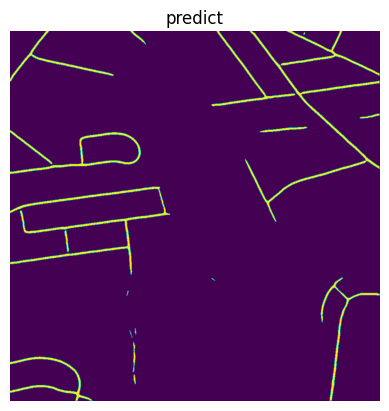

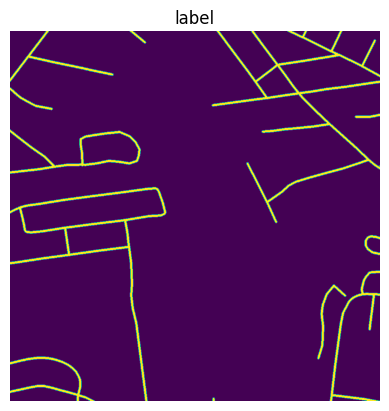

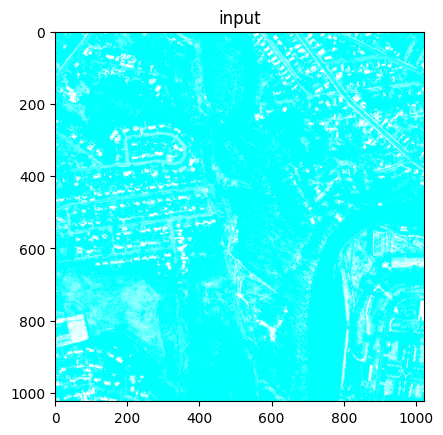

In [21]:
# model.load_state_dict(torch.load(r'C:\Users\User\segment\model.pt'))
%pip install torchsummary
from torchsummary import summary
model = smp.Unet(encoder_name='resnet34', in_channels=3, classes=1).to(device)
# print(summary(model,( 3, 32, 32)))
model.load_state_dict(torch.load(r'C:\Users\User\segment\checkpoints\best_0.59.pt'))
print(model)

model.eval()
test_loss = 0.0
test_total_iou = 0.0

with torch.no_grad():
    inputs, targets = val_dataset[2]
    targets[targets == 255] = 1
    # inputs = inputs[1]
    # targets = targets[1]
    inputs = inputs.to(device)
    # targets = targets.to(device)
    targets = targets.float().unsqueeze(1)
    outputs = model(inputs.unsqueeze(0))
    outputs = (outputs > 0.5).float()

    

fig, axes = plt.subplots()
plt.imshow(outputs.squeeze().cpu())
plt.title('predict')
plt.axis('off')
plt.show()
plt.imshow(targets.squeeze())
plt.title('label')
plt.axis('off')
plt.show()
inputs = inputs.squeeze().cpu()
inputs_transposed = np.transpose(inputs, (1, 2, 0))
plt.imshow(inputs_transposed)
plt.title('input')
# plt.axis('off')
plt.show()

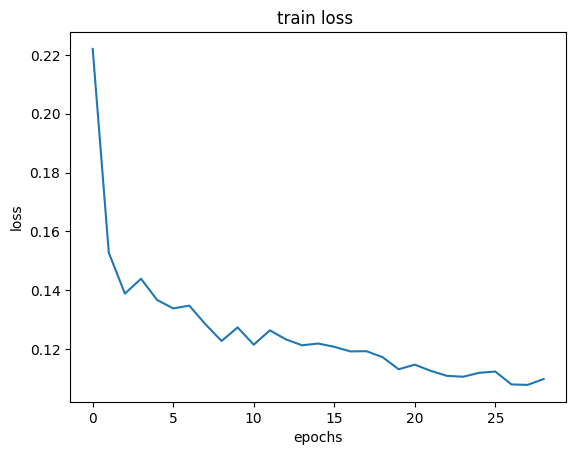

In [14]:

arr_train_loss = [0.22205975215445767,0.15272183320275298,0.13882877644117889,0.14387640746327135,0.1366780233812762,0.13378294127749968,0.13473708477911647,0.1284059698919992,0.122710744607019,0.12732247477984643,0.12145047037451116,0.12632290374588323,0.12325275642377836, 0.12124538025609008,0.1218377151736268,0.12073174407621762,0.1191587077269146,0.11923628877680581,0.11720463942300093,0.11309075684429289,0.11465677585419234,0.11253359826566937,0.11084630065136128,0.11054915874390989,0.11188385236236426,0.11231392366929097,0.1079382345348865,0.10776264146641568,0.10976057721150888]
arr_val_loss = [0.1741933450102806,
0.14634700119495392,
0.12021225690841675,
0.12253187969326973,
0.15873983502388,
0.10868828743696213,
0.12285144254565239,
0.1105620227754116,
0.09301689639687538,
0.11005979031324387,
0.1177249476313591,
0.14000558108091354,
0.11318027228116989,
0.1302114762365818,
0.10853227972984314,
0.12450145184993744,
0.11913000419735909,
0.10240832343697548,
0.116972666233778,
0.14994464069604874,
0.09688737243413925,
0.1095372661948204,
0.09883783012628555,
0.08063506335020065,
0.1231466718018055,
0.11460244283080101,
0.08586796186864376,
0.09311496838927269,
0.09237509965896606,
0.12118342518806458]

arr_iou_train = [0.08303577754248409,
0.27115152140212084,
0.32111082146737013,
0.33160290598011605,
0.34568809037746046,
0.36281867979635174,
0.3682530742810965,
0.38810302418206005,
0.40224279157973386,
0.40078809921818315,
0.40256339172209904,
0.41048497389268934,
0.41239216456483596,
0.42139031277191835,
0.43503852594012227,
0.42844541781984335,
0.43091583442998993,
0.4379080806813532,
0.4419088883323013,
0.44873959527506774,
0.4582012613787314,
0.4533194309438064,
0.45447818392056255,
0.4637370003441725,
0.4721492995766451,
0.46212951677742703,
0.45986471600418327,
0.47448819377166934,
0.4715991875110724,
0.47074957777788684]

arr_iou_val = [0.20412475773035738, 0.28883076480494513, 0.32998746814682123, 0.40077667505242365, 0.3979291298564729, 0.34693537473081104, 0.49882342180939454, 0.4695124840186973, 0.5195664482972644, 0.46075360066450327, 0.5431434662597846, 0.4461894741294222, 0.45316032090466496, 0.4898938935832719, 0.5497656173229732, 0.40555505866339386, 0.5120102890303599, 0.5041708839450262, 0.5184441241925801, 0.41600079877401475, 0.5528691170501647, 0.5184139165029129, 0.516553921084302, 0.5904686980343161, 0.5416597635626479, 0.543078942845668, 0.5566702930693149, 0.5265541068173808, 0.5578661282720152, 0.5313586107769994]


plt.plot(arr_train_loss)
plt.title('train loss ')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('train_loss_graph')
plt.show()

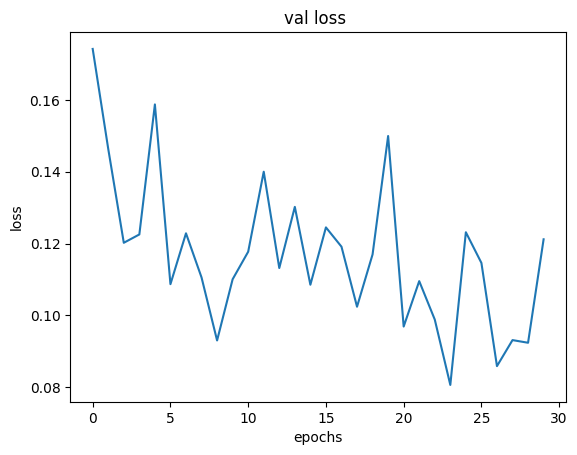

In [16]:
plt.plot(arr_val_loss)
plt.title('val loss ')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('train_loss_graph')
plt.show()

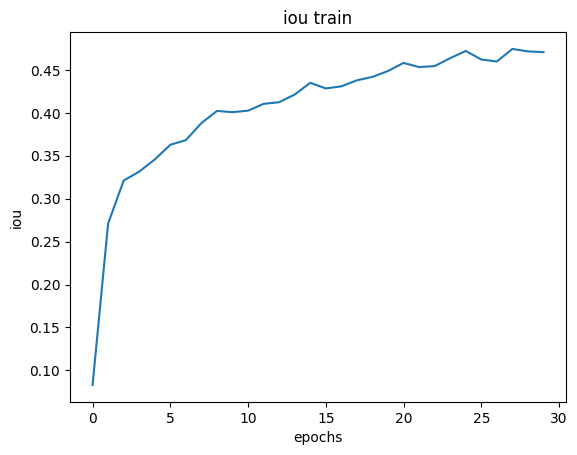

In [17]:
plt.plot(arr_iou_train)
plt.title('iou train')
plt.xlabel('epochs')
plt.ylabel('iou')
plt.savefig('train_loss_graph')
plt.show()

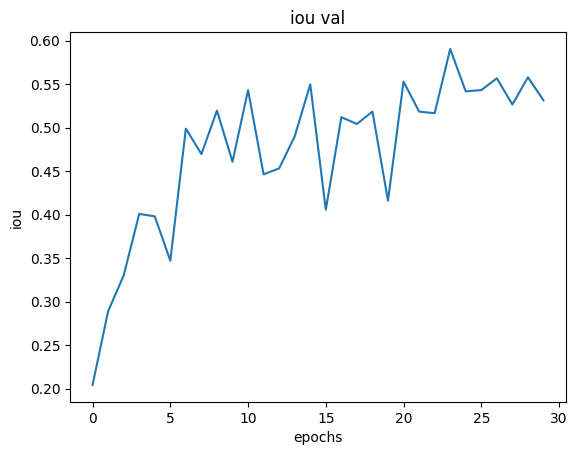

In [18]:
plt.plot(arr_iou_val)
plt.title('iou val')
plt.xlabel('epochs')
plt.ylabel('iou')
plt.savefig('train_loss_graph')
plt.show()